In [2]:
# Libraries
import numpy as np
import random
from numpy.random import default_rng
import matplotlib.pyplot as plt
from ete3 import *
#from ete3 import Tree, TreeNode, TreeStyle, NodeStyle, TextFace
import PyQt5
from decimal import Decimal, getcontext
rng = default_rng()
from PIL import Image
import math

## Structured Moran Simulation

In [3]:
# Algorithms
def StemBuilder(stem_population_size, stem_rate):
    # An ancestry list to containt cell relations
    stem_ancestry = list(np.zeros(2*stem_population_size-1))
    stem_ancestry[0] = (0, 0, "origin")
    # The initial population:
    stem_population = [0]
    time = 0
    next_id = 1
    while len(stem_population) != stem_population_size:
        # Calculating the rate parameter and the exact time when the event takes place
        rate_parameter = len(stem_population)*stem_rate
        time += np.random.exponential(scale=1/rate_parameter)
        # Sampling the population
        cell  = random.sample(range(0, len(stem_population)), 1)[0]
        # Running the event
        stem_ancestry[next_id] = (stem_population[cell], time, "stem")
        stem_population[cell] = next_id
        next_id += 1
        stem_ancestry[next_id] = (stem_population[cell], time, "stem")
        stem_population.append(next_id)
        next_id += 1
    
    return stem_population, stem_ancestry, time, next_id

def DiffBuilder(diff_population_size, diff_rate, stem_population, stem_ancestry, current_time, id, stem_rate):
    # An ancestry list to contain cell relations
    diff_ancestry = list(np.zeros(2*diff_population_size))
    original_ancestry = stem_ancestry + diff_ancestry
    
    time = current_time
    next_id = id
    # populattions:
    current_stem_population = stem_population
    diff_population = []
    # rate parameter
    rate_parameter = len(stem_population)*stem_rate
    
    while len(diff_population) != diff_population_size:
        time += np.random.exponential(scale=1/rate_parameter)
        # Events in the stem cell population
        stemcell1, stemcell2 = random.sample(range(0, len(current_stem_population)), 2)
        original_ancestry[next_id] = (current_stem_population[stemcell1], time, "Stem")
        current_stem_population[stemcell2] = next_id
        next_id += 1
        original_ancestry[next_id] = (current_stem_population[stemcell1], time, "Stem")
        current_stem_population[stemcell1] = next_id
        next_id += 1
        # Events in the diff cell population
        original_ancestry[next_id] = (current_stem_population[stemcell2], time, "Stem")
        diff_population.append(next_id)
        next_id += 1
        original_ancestry[next_id] = (current_stem_population[stemcell2], time, "Stem")
        diff_population.append(next_id)
        next_id += 1
    
    return original_ancestry, current_stem_population, diff_population, next_id

def EventDecider(p0):
    # Generating a random number between 0 and 1
    random_number = random.uniform(0,1)
    event = "string"
    # Deciding which evenet happens:
    if random_number < p0:
        event = "Stem"
    else:
        event = "Diff"
    return event

def Simulation(stem_population_size, stem_rate, diff_population_size, diff_rate):

    # Consturcting the Sten cell population
    temp_stem, temp_anc, current_time, id = StemBuilder(stem_population_size, stem_rate)
    
    # Constructing the Diff cell population
    original_ancestry, stem_population, diff_population, id = DiffBuilder(diff_population_size, diff_rate, temp_stem, temp_anc, current_time, id, stem_rate)
    
    population_size = stem_population_size + diff_population_size
    # The number of generations that will be created 
    iterations = population_size*population_size*10

    # Creating the two distinct populations
    #stem_population = np.zeros(stem_population_size, dtype=int)
    #diff_population = np.zeros(diff_population_size, dtype=int)

    # Rate of which either event happens and the mean time between events
    R = stem_population_size*stem_rate + diff_population_size*diff_rate
    scale_parameter = 1/R
    
    # The chance that the event of the stem cell population happens
    p0 = (stem_population_size*stem_rate)/R
    # The chance that the event of the diff cell population happens
    p1 = (diff_population_size*diff_rate)/R

    # An array to keep track of ancestry
    ancestry_cells = original_ancestry + list(np.zeros(4*iterations+1))
    #ancestry_cells[0] = (0, 0, "origin")
    #ancestry_times = np.zeros(4*iterations+1)

    # Running the simulation:
    time = 0
    next_id = id

    for iteration in range(iterations):
        # Time of the event
        time += np.random.exponential(scale=scale_parameter)
        # deciding which event happens
        event = EventDecider(p0)
        # deciding which 2 diff cells partake in the event
        diff_cell1, diff_cell2 = random.sample(range(0, diff_population_size), 2)
        # Running the events:
        if event == "Stem":
            # Events in the stem cell population
            stemcell1, stemcell2 = random.sample(range(0, stem_population_size), 2)
            ancestry_cells[next_id] = (stem_population[stemcell1], time, event)
            stem_population[stemcell2] = next_id
            next_id += 1
            ancestry_cells[next_id] = (stem_population[stemcell1], time, event)
            stem_population[stemcell1] = next_id
            next_id += 1
            # Events in the diff cell population
            ancestry_cells[next_id] = (stem_population[stemcell2],time, event)
            diff_population[diff_cell2] = next_id
            next_id += 1
            ancestry_cells[next_id] = (stem_population[stemcell2], time, event)
            diff_population[diff_cell1] = next_id
            next_id += 1
        else:
            ancestry_cells[next_id] = (diff_population[diff_cell1], time, event)
            diff_population[diff_cell2] = next_id
            next_id += 1
            ancestry_cells[next_id] = (diff_population[diff_cell1], time, event)
            diff_population[diff_cell1] = next_id
            next_id += 1
    
    return list(stem_population), list(diff_population), ancestry_cells

def DataTrimmer(ancestry):
    data = []
    for event in ancestry:
        if type(event) == tuple:
            data.append(event)


    # Separating the data
    ancestry_cells = []
    ancestry_times = []
    ancestry_types = []
    for event in data:
        ancestry_cells.append(event[0])
        ancestry_times.append(event[1])
        ancestry_types.append(event[2])

    return ancestry_cells, ancestry_times, ancestry_types

def TreeMaker(stem_population, diff_population, time_ancestry, ancestry, sample_size = 0):
        
    # Connecting the differentiated cell population and stem cell population
    present_population = stem_population + diff_population
    population_size = len(present_population)


    present_time = max(time_ancestry)
    
    # Sampleing the population in a list
    if sample_size == 0:
        population_sample = present_population
        sample_size = len(population_sample)
    else:
        population_sample=random.sample(present_population, sample_size)

    original_sample = population_sample.copy()

    # Identifying the types of cells within the sample
    sample_types = []
    for sample in population_sample:
        if sample in stem_population:
            sample_types.append("stem")
        else:
            sample_types.append("Diff")


    # Identifying the original node:
    youngest = max(population_sample)
    while youngest > len(present_population):
        father  = ancestry[youngest]
        youngest = father
    #print(f"The present population originated from the {youngest} position of the initial population")

    # Names of the sampled individuals
    strings = [repr(i) for i in population_sample]
    # Ages of the sampled individuals
    ages = [present_time]*sample_size
    # Creating the tree using the newick format
    while len(population_sample)>1:
        # Chosing the youngest individual within the sampled population
        youngest = max(population_sample)
        index = population_sample.index(youngest)
        # Determining the father of the youngest
        father  = ancestry[youngest]
        # Chaning the youngest to its father
        population_sample[index] = father
        # Searching the sample for individuals with the same father
        indicies = [index for index,value in enumerate(population_sample) if value == father] 
        # Should the sample have individuals with the same father tha newick string is formed 
        # and the individuals removed from the sample
        if len(indicies) > 1:
            fathers_age = time_ancestry[youngest]  #ids give the age of a node as: age = next_id // 2, e.g. 31//2==30//2==15
            smaller_index, larger_index = sorted(indicies)       
            strings[smaller_index] = \
                "("+strings[smaller_index]+":"+repr(ages[smaller_index]-fathers_age)\
            +","+strings[larger_index]+":"+repr(ages[larger_index]-fathers_age) + ")"
            ages[smaller_index]= fathers_age
            population_sample.pop(larger_index)
            strings.pop(larger_index)
            ages.pop(larger_index)      

    newick_string = strings[0]+";"

    return newick_string, original_sample, sample_types

def CoalescentTimeCalculator(newick_string=str, time_ancestry=list, tree = object):
    present_time = max(time_ancestry)
    # Getting the leaves of the tree
    leaves = tree.get_leaves()
    # A list that will hold the coalescent times
    coalescent_times = []
    # cycling through the leaves and getting all their ancesotrs. Than cycling through their ancestors and calulaiing the distance between ancestor and leaf
    # if the distance is not in coalescent_time than we append it
    for leaf in leaves:
        ancestors = leaf.get_ancestors()
        for ancestor in ancestors:
            time = ancestor.get_distance(leaf)
            ancestor.add_features(coalescent_time = time)
            if time not in coalescent_times:
                coalescent_times.append(time)
            else:
                coalescent_times.append()
    coalescent_times.sort()
    print(len(coalescent_times))
    #coalescent_times.append(present_time - coalescent_times[-1])
    
    return coalescent_times

def CoalescentTimeCalculator(newick_string=str, time_ancestry=list, tree = object):
    present_time = max(time_ancestry)
    # Getting the leaves of the tree
    leaves = tree.get_leaves()
    # A list that will hold the coalescent times
    coalescent_times = []
    # cycling through the leaves and getting all their ancesotrs. Than cycling through their ancestors and calulaiing the distance between ancestor and leaf
    # if the distance is not in coalescent_time than we append it
    for leaf in leaves:
        ancestors = leaf.get_ancestors()
        for ancestor in ancestors:
            time = ancestor.get_distance(leaf)
            ancestor.add_features(coalescent_time = time)
            if time not in coalescent_times:
                coalescent_times.append(time)
            else:
                coalescent_times.append()
    coalescent_times.sort()
    print(len(coalescent_times))
    #coalescent_times.append(present_time - coalescent_times[-1])
    
    return coalescent_times

In [4]:
# This now work good!!!
def CoalescentTimeCalculator2(newick_string=str, time_ancestry=list, tree = object):
    # Getting the leaves of the tree
    leaves = tree.get_leaves()
    # A list that will hold the coalescent times
    coalescent_times = []
    # cycling through the leaves and getting all their ancesotrs. Than cycling through their ancestors and calulaiing the distance between ancestor and leaf
    # if the distance is not in coalescent_time than we append it
    ancestors_list = []
    for leaf in leaves:
        ancestors = leaf.get_ancestors()
        for ancestor in ancestors:
            time = ancestor.get_distance(leaf)
            ancestor.add_features(coalescent_time = time)
            if ancestor not in ancestors_list:
                coalescent_times.append(time)
                ancestors_list.append(ancestor)
    coalescent_times.sort()
    print(len(coalescent_times))
    
    
    return coalescent_times

In [5]:
stem_population, diff_population, ancestry = Simulation(20, 50, 180, 200)
ancestry_cells, ancestry_times, ancestry_types = DataTrimmer(ancestry)
newick_string, sampled_population, sampled_types = TreeMaker(stem_population, diff_population, ancestry_times, ancestry_cells, sample_size=0)
tree = Tree(newick_string)
coalescent_times = CoalescentTimeCalculator2(newick_string, ancestry_times, tree)
print(newick_string)

199
((((((((821940:0.005220730385502748,(((822008:0.004270481784628188,((822007:0.004270481784628188,822010:0.004270481784628188):0.0,822009:0.004270481784628188):0.0):0.0009502486008745592,(822238:0.0007755232181576588,822237:0.0007755232181576588):0.004445207167345089):0.0,822000:0.005220730385502748):0.0):0.020534207361846413,(820545:0.025223079686119476,(((822073:0.003188309635413944,822076:0.003188309635413944):0.0,((822221:0.0009312687786593443,822222:0.0009312687786593443):0.0004025141530661358,822191:0.0013337829317254801):0.0018545267036884638):0.0,(((822275:0.00028849608167114127,822278:0.00028849608167114127):0.0,822277:0.00028849608167114127):0.0,822276:0.00028849608167114127):0.0028998135537428027):0.022034770050705532):0.0005318580612296842):0.007611230150970982,821858:0.03336616789832014):0.04232516131765074,((((821860:0.006101644905438519,821859:0.006101644905438519):0.008362483522057929,(((822146:0.002075096754447614,822145:0.002075096754447614):0.008407867267992586,(8

In [6]:
# Indentifying which coalescent event was which type:
diff_coalesence = []
stem_coalesence = []
for coalescence in coalescent_times:
    time = max(ancestry_times)-coalescence 
    for index, _t in enumerate(ancestry_times):
        if math.isclose(_t, time):
            break
    if ancestry_types[index] == "Diff":
        diff_coalesence.append(coalescence)
    else:
        stem_coalesence.append(coalescence)

In [7]:
# Creating the tree object
#tree = Tree(newick_string)
# Giving every node a new attribute to distinguish between types of coalesence
for n in tree.traverse():
   n.add_features(celltype = "undecided")

leaves = tree.get_leaves()
for leaf in leaves:
        ancestors = leaf.get_ancestors()
        for ancestor in ancestors:
            time = ancestor.get_distance(leaf)
            if time in stem_coalesence:
                 ancestor.celltype = "Stem_ancestor"
            else:
                 ancestor.celltype = "Diff_ancestor"

The hight of the tree is 0.259420657799172


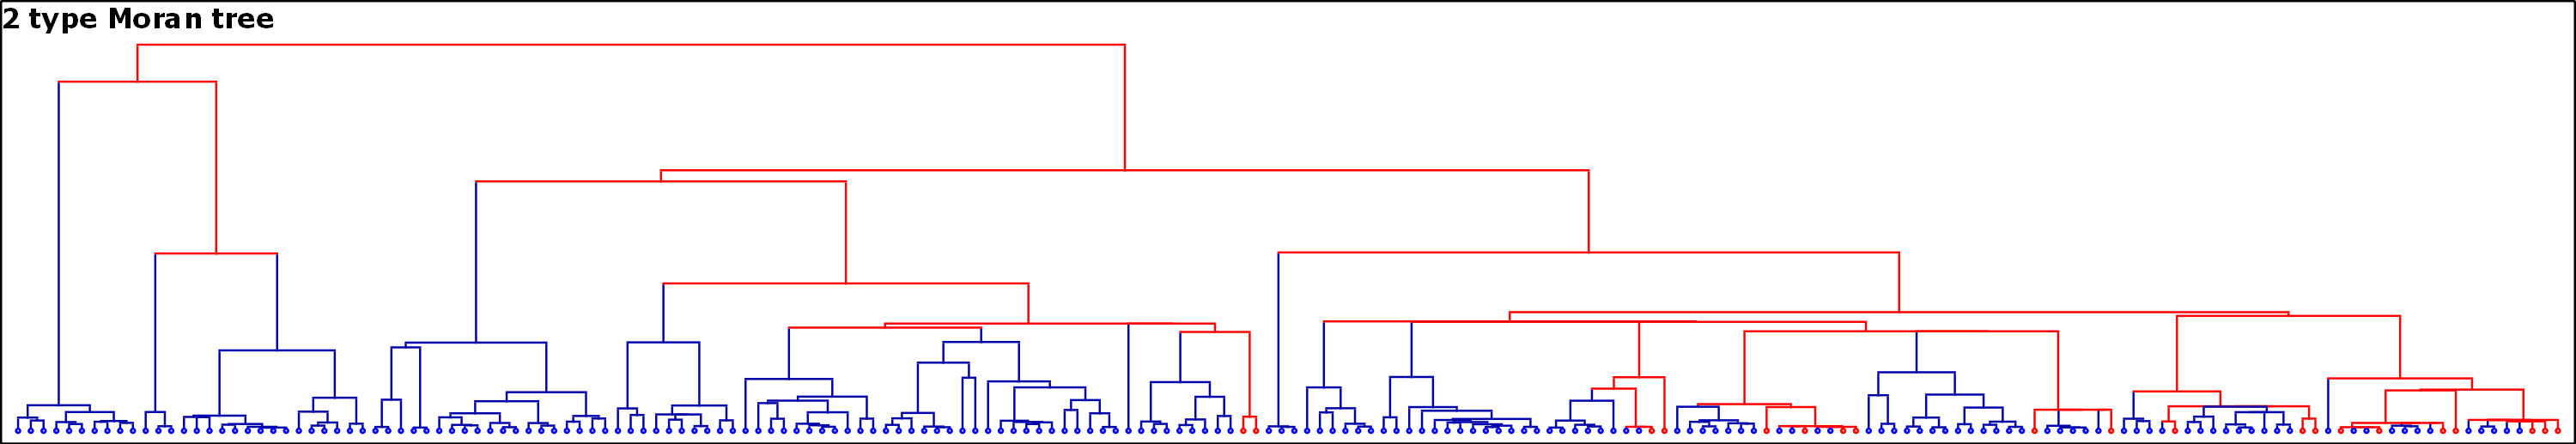

In [8]:
# Creating the tree style for display
# The Basic Tree style:
ts = TreeStyle()
ts.show_leaf_name = False
ts.show_branch_length = False
ts.branch_vertical_margin = 4
ts.show_branch_support = False
ts.draw_guiding_lines = False
ts.aligned_header = False
ts.legend = False
ts.show_scale = False
#ts.scale = 3000
ts.rotation = 90
#ts.title.add_face(TextFace("Two-type Moran Simulation Coalescent Tree"), column=0)

# The differentiated ancestor node style:
diff_anc_style = NodeStyle()
diff_anc_style["shape"] = "sphere"
diff_anc_style["size"] = 0
diff_anc_style["fgcolor"] = "blue"
diff_anc_style["vt_line_width"] = 1
diff_anc_style["hz_line_width"] = 1
diff_anc_style["vt_line_color"] = "#0000aa"
diff_anc_style["hz_line_color"] = "#0000aa"

# The stem ancestor node style:
stem_anc_style = NodeStyle()
stem_anc_style["shape"] = "sphere"
stem_anc_style["size"] = 0
stem_anc_style["fgcolor"] = "blue"
stem_anc_style["vt_line_width"] = 1
stem_anc_style["hz_line_width"] = 1
stem_anc_style["vt_line_color"] = "#ff0000"
stem_anc_style["hz_line_color"] = "#ff0000"


for n in tree.traverse():
   if n.celltype == "Stem_ancestor":
      n.set_style(stem_anc_style)
   if n.celltype == "Diff_ancestor":
      n.set_style(diff_anc_style)
   else:
      pass

# The differentiated cells node type:
diff_nstyle = NodeStyle()
diff_nstyle["shape"] = "sphere"
diff_nstyle["size"] = 2
diff_nstyle["fgcolor"] = "blue"
diff_nstyle["vt_line_width"] = 1
diff_nstyle["hz_line_width"] = 1
diff_nstyle["vt_line_color"] = "#0000aa"
diff_nstyle["hz_line_color"] = "#0000aa"
# The Stem cell node type
stem_nstyle = NodeStyle()
stem_nstyle["shape"] = "sphere"
stem_nstyle["size"] = 2
stem_nstyle["fgcolor"] = "red"
stem_nstyle["vt_line_width"] = 1
stem_nstyle["hz_line_width"] = 1
stem_nstyle["vt_line_color"] = "#ff0000"
stem_nstyle["hz_line_color"] = "#ff0000"


# Assigning the correnct color to the correct node
leaves = tree.get_leaves()
for sample_index, sample_name in enumerate(sampled_population):
   type_of_sample = sampled_types[sample_index]
   node = tree.get_leaves_by_name(str(sample_name))[0]
   if type_of_sample == "Diff":
      node.set_style(diff_nstyle)
      node.celltype = "Diff"
   else:
      node.set_style(stem_nstyle)
      node.celltype = "Stem"
ts.margin_bottom = 5
ts.margin_top = 5
ts.show_border = True
ts.margin_left = 5
ts.margin_right = 5
#image = tree.render("tree.png", units="mm", w = 6000, h = 5000, tree_style=ts)
ts.title.add_face(TextFace("2 type Moran tree", bold = True), column=0)
print(f"The hight of the tree is {coalescent_times[-1]}")
tree.render("%%inline", units="px",w = 3000, tree_style=ts)

In [9]:
# Calculating how many samples were stem cells and differentiated cells
sample_stem = sampled_types.count("stem")
sample_diff = sampled_types.count("Diff")

In [10]:
# Creating the r parameter for the whole coalesence:
coalesence_r = list(np.arange(1, len(coalescent_times)+1))
coalesence_r.reverse()
coalescent_times.insert(0, 0)
coalesence_r.insert(0, sample_diff+sample_stem)

In [11]:
# Searching tree for when the number of differentiated cells were reduced
ancestors = tree.search_nodes(celltype = "Stem_ancestor") + tree.search_nodes(celltype = "Diff_ancestor")
diff_reduction_times = []
flip_times = []
for ancestor in ancestors:
    children = ancestor.get_children()
    for child in children:
        if child.celltype == "Diff_ancestor" or child.celltype == "Diff":
            diff_reduction_times.append(ancestor.coalescent_time)
            break

diff_reduction_times.sort()
coalescence_diff = list(np.arange(0, len(diff_reduction_times)))
coalescence_diff.reverse()
diff_reduction_times.insert(0,0)
coalescence_diff.insert(0, sample_diff)

if diff_reduction_times[-1]< coalescent_times[-1]:
    diff_reduction_times.append(coalescent_times[-1])
    coalescence_diff.append(0)

print(len(diff_reduction_times), len(diff_coalesence))

180 145


In [12]:
# Calculating the change in stem cell numbers 
coalescence_stem = []
stem_times = [0]
index = 0
for col_index, time in enumerate(coalescent_times):
    current_diff_time = diff_reduction_times[index]
    current_diff_number = coalescence_diff[index]
    if time <= current_diff_time:
        coalescence_stem.append(coalesence_r[col_index]-coalescence_diff[index])
    if time > current_diff_time:
        coalescence_stem.append(coalesence_r[col_index]-coalescence_diff[index+1])
        index += 1

In [22]:
def l2(t,N):
    return 1/(N**2/2 - N**2/t)

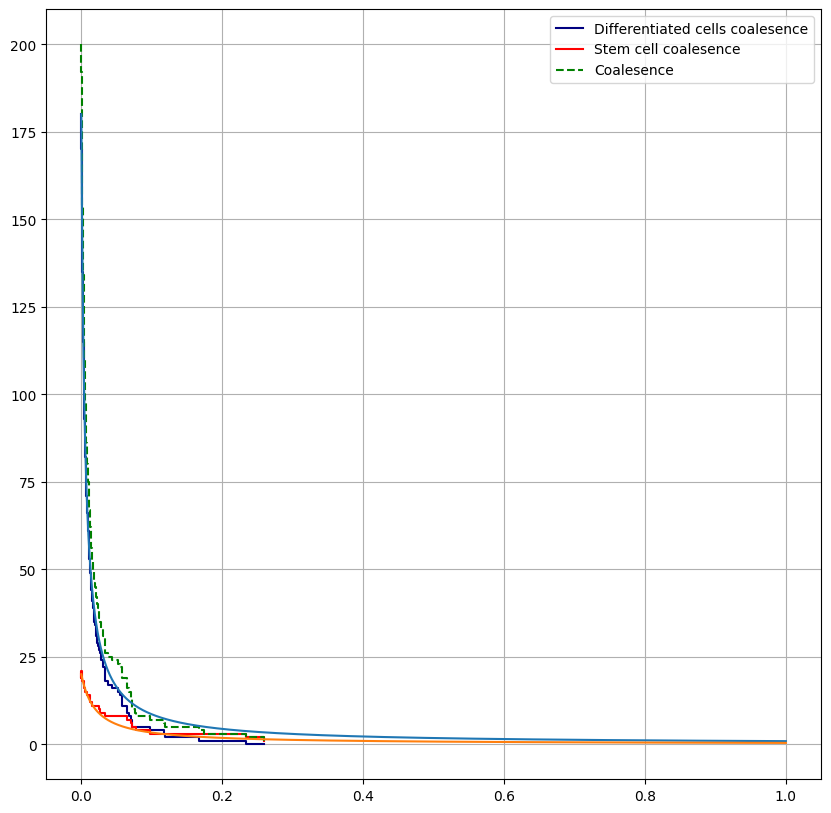

In [25]:
# plotting the coalescent times:
plt.figure(figsize=(10,10))
plt.step(diff_reduction_times, coalescence_diff, where="post", ls = "-", color = "navy", label = "Differentiated cells coalesence")
plt.step(coalescent_times, coalescence_stem, where="post", ls = "-", color = "red", label = "Stem cell coalesence")
plt.step(coalescent_times, coalesence_r, where="post", ls = "--", color = "green", label = "Coalesence")
#plt.xlim(0,0.05)
plt.yscale("log")
#plt.yticks([1, 10])
plt.xscale("log")
t = np.linspace(0, 1, 1000000)
def l(t, N):
    return N/(t+1)
plt.plot(t, l(t*200, 180))
plt.plot(t, l(t*50, 20))
plt.legend()
plt.grid()

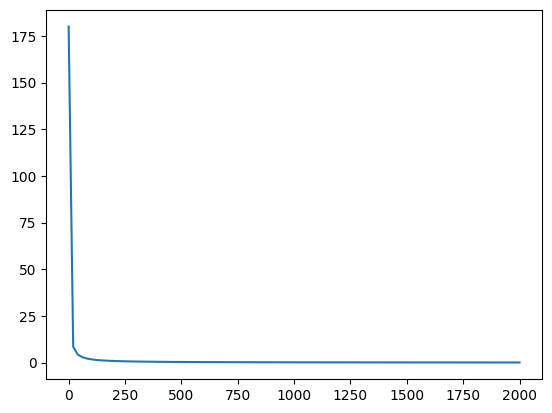

In [14]:
t = np.linspace(0, 2000, 100)
def l(t, N):
    return N/(t+1)
plt.plot(t, l(t, 180))

# Michel Fák

In [15]:
michel = Tree("(((((((((PD43974af2:0.4720004564,PD43974mf:0.4720004564)100:0.5032195653,(PD43974jq:0.9745585488,PD43974gr2:0.9745585488)80:0.0006614729463)100:0.005410628512,PD43974nl:0.9806306502)37:0.0003334921622,(((((((((((((((((PD43974ag2:0.3524799325,PD43974y2:0.3524799325)100:0.02948104768,(PD43974iu:0.3698011139,((PD43974jz:0.1792522913,PD43974ns:0.1792522913)100:0.180428585,PD43974nk:0.3596808763)100:0.01012023762)100:0.01215986631)100:0.007444875069,(PD43974op:0.3778494063,PD43974pv:0.3778494063)100:0.01155644902)100:0.01503263515,(PD43974lc:0.3847208027,PD43974fe:0.3847208027)100:0.01971768769)100:0.02701303913,(PD43974fa:0.4070627328,PD43974cg:0.4070627328)100:0.02438879672)100:0.02430638832,((PD43974jv:0.4142080967,(PD43974b3:0.3801506323,PD43974fz:0.3801506323)100:0.03405746434)100:0.01643323651,PD43974ai:0.4306413332)100:0.02511658471)100:0.01690044951,(((PD43974av:0.3897269094,PD43974iv:0.3897269094)98:0.005597780008,PD43974jk:0.3953246894)100:0.05903026706,(PD43974ei:0.4432128719,PD43974i:0.4432128719)100:0.01114208455)100:0.01830341097)100:0.008793947556,(PD43974ev:0.4678804196,PD43974ga:0.4678804196)100:0.01357189532)100:0.01968026722,((PD43974et:0.2689021297,PD43974oo:0.2689021297)100:0.1876773002,PD43974pl:0.4565794299)100:0.04455315226)100:0.0109051692,(((((PD43974kq:0.2950286923,PD43974fi:0.2950286923)100:0.07531887104,PD43974ov:0.3703475634)100:0.03750323064,PD43974hc:0.407850794)100:0.05979984618,PD43974gg:0.4676506402)100:0.0204786438,PD43974kv:0.488129284)100:0.02390846739)100:0.01782361595,PD43974bw3:0.5298613673)100:0.01170071639,(PD43974kh:0.4717536722,PD43974gs:0.4717536722)100:0.06980841148)100:0.008304620797,((((PD43974ah2:0.5017082128,((PD43974ik:0.4176999718,PD43974as2:0.4176999718)100:0.06366082628,PD43974fr:0.4813607981)100:0.02034741467)100:0.02206547072,(PD43974ay:0.5158132687,PD43974mj:0.5158132687)100:0.007960414849)100:0.006419985186,((((((PD43974iw:0.3887981287,PD43974lf:0.3887981287)100:0.03248334559,PD43974jc:0.4212814743)100:0.03800958477,((PD43974jr:0.4145277859,PD43974eg2:0.4145277859)100:0.04037825727,PD43974ie:0.4549060432)100:0.004385015924)100:0.03232499255,PD43974es2:0.4916160516)100:0.01395929208,((((PD43974t:0.4449138129,PD43974co2:0.4449138129)100:0.004900499308,PD43974pm:0.4498143122)100:0.01179985549,PD43974ph:0.4616141677)100:0.03483672968,PD43974gv:0.4964508974)100:0.009124446311)100:0.006995886854,((PD43974ez:0.4941002552,(((PD43974ng:0.4360426867,PD43974bv:0.4360426867)100:0.05241044957,PD43974ct2:0.4884531362)100:0.0006971520248,PD43974ou:0.4891502883)100:0.004949966969)100:0.00988182045,PD43974fj:0.5039820757)100:0.008589154903)100:0.01762243811)100:0.01131179026,(((((((((PD43974ap2:0.3183688142,PD43974cf2:0.3183688142)100:0.1283944547,(PD43974kc:0.4317364676,((PD43974kt:0.2720331006,PD43974hd:0.2720331006)100:0.04455911409,PD43974mm:0.3165922147)100:0.1151442529)100:0.01502680131)100:0.02748035815,(PD43974kx:0.4279222842,PD43974ce:0.4279222842)100:0.04632134289)100:0.01511006964,PD43974eu2:0.4893536967)100:0.007545346688,PD43974la:0.4968990434)100:0.008264192471,(((((PD43974en:0.4251414521,((PD43974az:0.3910054957,PD43974eo:0.3910054957)100:0.01341129307,PD43974gc2:0.4044167887)100:0.02072466332)100:0.02779186928,PD43974fb:0.4529333213)100:0.02718105832,((((PD43974ii:0.3346501906,PD43974k:0.3346501906)100:0.04091028531,(PD43974jh:0.2997853971,PD43974f2:0.2997853971)100:0.0757750788)100:0.09014343516,(PD43974bd:0.3947936329,PD43974ho:0.3947936329)100:0.07091027811)100:0.003440172743,PD43974ck2:0.4691440838)100:0.01097029589)100:0.008787646258,PD43974bf:0.4889020259)100:0.008816941513,(PD43974lh:0.4916120017,PD43974bp2:0.4916120017)100:0.006106965713)100:0.007444268427)100:0.004770318935,(((PD43974ot:0.3543474621,PD43974cp:0.3543474621)100:0.1092926184,PD43974e:0.4636400805)100:0.03435248192,PD43974bt:0.4979925625)100:0.01194099233)100:0.006842391836,PD43974ey:0.5167759466)100:0.01712636034,(((PD43974ih:0.3934319269,PD43974gh:0.3934319269)100:0.08566187274,(((PD43974kb:0.116156462,PD43974gf:0.116156462)100:0.33809833,PD43974em2:0.454254792)100:0.01134142989,(((PD43974ke:0.2796207161,PD43974l:0.2796207161)100:0.1488181924,(PD43974ox:0.4181623148,PD43974bn:0.4181623148)100:0.01027659377)100:0.01419076203,PD43974id:0.4426296706)100:0.02296655137)100:0.0134975777)100:0.0399867747,((PD43974kf:0.3683262031,PD43974pt:0.3683262031)100:0.1311702672,PD43974hl:0.4994964704)100:0.01958410396)100:0.01482173264)100:0.007603151985)100:0.008361245559)100:0.05213580421,((PD43974ep:0.5395157494,(PD43974bm2:0.5158027809,PD43974ps:0.5158027809)100:0.02371296848)100:0.01558177244,(((PD43974jm:0.4809618427,PD43974ks:0.4809618427)100:0.007317715767,PD43974pu:0.4882795584)100:0.0147080157,(PD43974ll:0.4580581108,(PD43974lt:0.4437324165,(PD43974pf:0.4087041015,PD43974ed:0.4087041015)100:0.03502831505)100:0.01432569424)100:0.04492946336)100:0.05210994767)100:0.0469049869)100:0.3680333261,((((PD43974aj2:0.5757654727,((PD43974ij:0.3575540449,PD43974aq:0.3575540449)100:0.02618448509,PD43974bu:0.38373853)100:0.1920269427)100:0.009312587743,PD43974gl:0.5850780604)100:0.04006993358,(PD43974or:0.6088216463,PD43974eh:0.6088216463)100:0.01632634775)100:0.05751993878,(PD43974os:0.486823155,(PD43974if:0.3179804328,PD43974gi:0.3179804328)100:0.1688427222)100:0.1958447778)100:0.287367902)99:0.002066455094,(((((PD43974hu:0.5189754856,PD43974jl:0.5189754856)100:0.4505319749,(PD43974au:0.5945339397,PD43974er:0.5945339397)100:0.3749735208)99:0.000631087027,(((PD43974io:0.3905586361,PD43974n2:0.3905586361)78:0.003329818798,(PD43974mq:0.3758301401,PD43974fs2:0.3758301401)100:0.01805831481)100:0.5759202315,(((PD43974je:0.5728342772,PD43974pp:0.5728342772)100:0.02809396458,(PD43974jw:0.5776708528,(PD43974om:0.5539403098,((((PD43974ls:0.4115402098,PD43974hf:0.4115402098)100:0.07122712721,PD43974u2:0.482767337)100:0.01823979652,PD43974hp:0.5010071336)100:0.04662808335,PD43974gq:0.5476352169)100:0.00630509283)100:0.023730543)100:0.02325738907)100:0.3685524162,(((PD43974ml:0.2770051677,PD43974bg2:0.2770051677)100:0.2974631239,(PD43974ft2:0.5446068639,PD43974hq:0.5446068639)100:0.02986142765)100:0.0401676395,(PD43974pn:0.6020885753,PD43974ht:0.6020885753)100:0.0125473558)100:0.354844727)17:0.0003280283379)11:0.0003298611046)99:0.001309065613,(((PD43974it:0.6183993337,PD43974hi:0.6183993337)100:0.3510928995,PD43974jb:0.9694922332)100:0.0006555854535,PD43974py:0.9701478186)99:0.001299794484)9:0.0003270261513,PD43974pi:0.9717746393)20:0.0003276506114)100:0.007505344225,(((((PD43974hv:0.9730135295,PD43974lr:0.9730135295)52:0.0006191105989,(PD43974nj:0.9733300622,PD43974hz:0.9733300622)18:0.0003025778926)91:0.001200977904,(PD43974nq:0.9728272768,PD43974ej:0.9728272768)100:0.002006341198)26:0.0003083931044,((((PD43974ak:0.9731512454,PD43974be2:0.9731512454)49:0.000325309267,PD43974mk:0.9734765546)4:0.0003293633166,PD43974pk:0.973805918)18:0.0006671499023,PD43974js:0.9744730679)67:0.0006689432679)73:0.000639427539,((PD43974z:0.973235546,PD43974bo:0.973235546)98:0.001911106524,PD43974hb2:0.9751466526)73:0.00063478611)100:0.003826195446)99:0.001356508281)97:0.0006779152497,PD43974fc:0.9816420576)100:0.003389601356,((((PD43974am2:0.9718862713,PD43974fp:0.9718862713)100:0.004303354219,PD43974hj:0.9761896255)99:0.001271229919,(PD43974fw:0.9768530711,PD43974o2:0.9768530711)98:0.0006077843596)99:0.004293443575,(((PD43974hw:0.9769824007,((PD43974ow:0.5629015437,(PD43974ff:0.5266434662,PD43974gp:0.5266434662)100:0.03625807749)100:0.09716072959,(PD43974pq:0.4891200626,PD43974s2:0.4891200626)100:0.1709422107)100:0.3169201274)100:0.0006927976266,(PD43974oy:0.9763653591,PD43974ge:0.9763653591)100:0.001309839197)100:0.003397587864,PD43974bq:0.9810727862)98:0.0006815127914)99:0.00327736001)27:0.0003381952474,((PD43974in:0.9844222064,((PD43974jg:0.9790226266,PD43974m:0.9790226266)100:0.005081572247,((PD43974kz:0.9711886259,PD43974fm:0.9711886259)100:0.002564067908,PD43974hn:0.9737526938)100:0.01035150507)19:0.0003180075659)13:0.0003117307621,(PD43974cl2:0.9812969933,PD43974gd:0.9812969933)100:0.003436943906)95:0.0006359170856)99:0.001349203028,(((((((((PD43974al2:0.5025685105,PD43974fd:0.5025685105)99:0.009574173973,PD43974q2:0.5121426845)100:0.4582812752,PD43974lu:0.9704239597)99:0.003947944948,(PD43974ku:0.9717486747,(PD43974ax2:0.9714283595,PD43974c:0.9714283595)39:0.0003203151446)99:0.002623229981)100:0.007855126515,(PD43974w:0.972005535,PD43974ia:0.972005535)100:0.01022149614)97:0.0006591900531,(((((PD43974an2:0.7044757517,(PD43974jo:0.6631298399,PD43974ch2:0.6631298399)100:0.04134591176)100:0.2711147262,PD43974cd2:0.9755904778)78:0.0003194616552,(PD43974jf:0.975581038,PD43974ha2:0.975581038)49:0.0003289014781)99:0.001935293448,(PD43974ip:0.9742011106,PD43974fv:0.9742011106)100:0.00364412231)100:0.003165884189,((PD43974bb:0.9746948637,PD43974cr2:0.9746948637)100:0.002658165616,PD43974bl:0.9773530293)100:0.003658087799)83:0.001875104091)26:0.0003200822672,(((((PD43974kg:0.5491969732,PD43974cn:0.5491969732)94:0.01285949525,(PD43974lb:0.5039673105,PD43974gt:0.5039673105)100:0.05808915795)100:0.4132895724,PD43974px:0.9753460408)100:0.002634794284,((PD43974lz:0.9709943503,PD43974hh:0.9709943503)100:0.002507070512,PD43974gw:0.9735014208)100:0.004479414321)99:0.003252415955,(PD43974kj:0.9747878246,PD43974no:0.9747878246)100:0.006445426479)99:0.001973052399)18:0.0003230559933,((((((((PD43974ar2:0.6888443597,(PD43974ld:0.6759049987,PD43974fy2:0.6759049987)100:0.012939361)100:0.2844158261,((PD43974is:0.5625617142,PD43974lm:0.5625617142)100:0.01462655164,(PD43974cj:0.5501993819,PD43974gj:0.5501993819)100:0.02698888398)100:0.3960719199)100:0.001218750893,(PD43974lv:0.9732651236,(((PD43974bk2:0.5978177584,(PD43974gb:0.5652156048,PD43974j:0.5652156048)100:0.03260215354)100:0.059573914,PD43974cc2:0.6573916724)100:0.01904282956,PD43974pj:0.6764345019)100:0.2968306217)100:0.001213812988)99:0.00121645997,((((PD43974ji:0.4153234972,PD43974by2:0.4153234972)100:0.01965499031,(PD43974ju:0.384255448,PD43974po:0.384255448)100:0.05072303954)100:0.006808610421,(PD43974fg:0.3059163033,PD43974gx2:0.3059163033)100:0.1358707947)100:0.08645984772,(PD43974jp:0.4889596071,PD43974lk:0.4889596071)100:0.03928733854)100:0.4474484509)99:0.001227685079,((((((PD43974hx:0.4457693026,PD43974hr:0.4457693026)100:0.03546957665,(PD43974aw2:0.4776692354,PD43974pg:0.4776692354)100:0.003569643844)100:0.02424659228,(((PD43974km:0.08108876359,PD43974go:0.08108876359)100:0.3687112725,PD43974ae:0.4498000361)100:0.00830656816,PD43974pe:0.4581066042)100:0.04737886728)100:0.01809578735,PD43974cs:0.5235812589)100:0.4490128647,PD43974ci:0.9725941236)100:0.003997230953,PD43974cq2:0.9765913545)100:0.0003317271504)100:0.001890112826,PD43974il:0.9788131945)100:0.001888589467,(PD43974jy:0.9750587978,PD43974h:0.9750587978)100:0.00564298615)100:0.002511789798,((((PD43974eq:0.6506344567,PD43974bi:0.6506344567)100:0.3199563426,PD43974lj:0.9705907993)100:0.003821738366,(PD43974fk:0.7114174175,PD43974gz2:0.7114174175)100:0.2629951202)29:0.0003237854444,PD43974pb:0.9747363231)100:0.008477250609)16:0.0003157857186)68:0.001275269442,(PD43974v:0.9756518513,(PD43974mn:0.9714918449,PD43974cb2:0.9714918449)92:0.00416000639)100:0.00915277759)100:0.001914428361)100:0.01328094273,((((((PD43974ao2:0.9783203233,(((PD43974im:0.6512334924,((PD43974ir:0.6206168359,PD43974kd:0.6206168359)100:0.02155382288,PD43974fn:0.6421706588)100:0.009062833642)100:0.3251861882,PD43974kn:0.9764196806)98:0.0006203401819,(((PD43974iz:0.5407085242,(PD43974qa:0.5021043378,PD43974ac2:0.5021043378)100:0.03860418641)100:0.02507231518,(PD43974mp:0.5503562384,(PD43974pw:0.5183734988,PD43974ib:0.5183734988)100:0.03198273965)100:0.01542460102)100:0.4099580955,((PD43974lw:0.9741909131,PD43974fx:0.9741909131)100:0.001232642746,(PD43974md:0.9712295659,PD43974pd:0.9712295659)100:0.00419399)99:0.0003153790712)99:0.00130108585)99:0.001280302487)100:0.004463966926,(PD43974iq:0.9789247752,((PD43974jt:0.969293885,PD43974fu:0.969293885)100:0.008333585841,(PD43974mz:0.9762605915,PD43974ab2:0.9762605915)100:0.001366879309)100:0.001297304406)100:0.003859514955)100:0.003834084616,(PD43974ef:0.983324798,PD43974fq2:0.983324798)100:0.003293576815)100:0.004477897322,(PD43974mu:0.9837844468,PD43974gy:0.9837844468)100:0.007311825376)100:0.002545832253,(((((PD43974bc:0.6102692435,PD43974p:0.6102692435)100:0.007364969018,PD43974bj:0.6176342125)100:0.3699646895,((((PD43974iy:0.9843020095,PD43974jn:0.9843020095)41:0.0003296727265,((PD43974bs:0.9839752695,PD43974bz:0.9839752695)20:0.0003224337869,PD43974cm3:0.9842977033)46:0.0003339789843)41:0.0006645727036,PD43974hy:0.9852962549)36:0.0003313104107,PD43974jd:0.9856275654)84:0.001971336705)100:0.003176224882,(((((PD43974jj:0.9816181532,PD43974el:0.9816181532)100:0.0003087815063,PD43974hm:0.9819269347)100:0.002488323968,PD43974lg:0.9844152586)100:0.005722508533,(PD43974ew:0.9830994215,(PD43974fo:0.9827759103,PD43974r2:0.9827759103)22:0.0003235112082)100:0.007038345638)15:0.0003184876997,(PD43974on:0.9852763856,PD43974hs:0.9852763856)100:0.00517986929)5:0.0003188720883)12:0.0003183154118,((PD43974ix:0.9877850237,PD43974fh:0.9877850237)90:0.002029953917,((PD43974bx2:0.6790532274,PD43974he:0.6790532274)100:0.01478371239,PD43974gu:0.6938369398)100:0.2959780379)98:0.001278464704)100:0.002548662036)100:0.001910413112,((((PD43974at:0.9845272373,PD43974ko:0.9845272373)100:0.004140348809,((PD43974ok:0.9842089463,PD43974ig:0.9842089463)100:0.0006327293381,PD43974hg2:0.9848416756)100:0.003825910462)99:0.0006143481484,PD43974ja:0.9892819342)100:0.00186093955,(PD43974ad:0.9905044226,((((PD43974ee:0.9818494171,(PD43974br:0.9815326036,PD43974g2:0.9815326036)83:0.0003168135217)33:0.0006094096508,PD43974ex:0.9824588267)100:0.0036676738,PD43974mv:0.9861265005)100:0.001846360105,PD43974ic:0.9879728606)100:0.002531562008)99:0.0006384511337)100:0.004409643729)100:0.004447482494);")

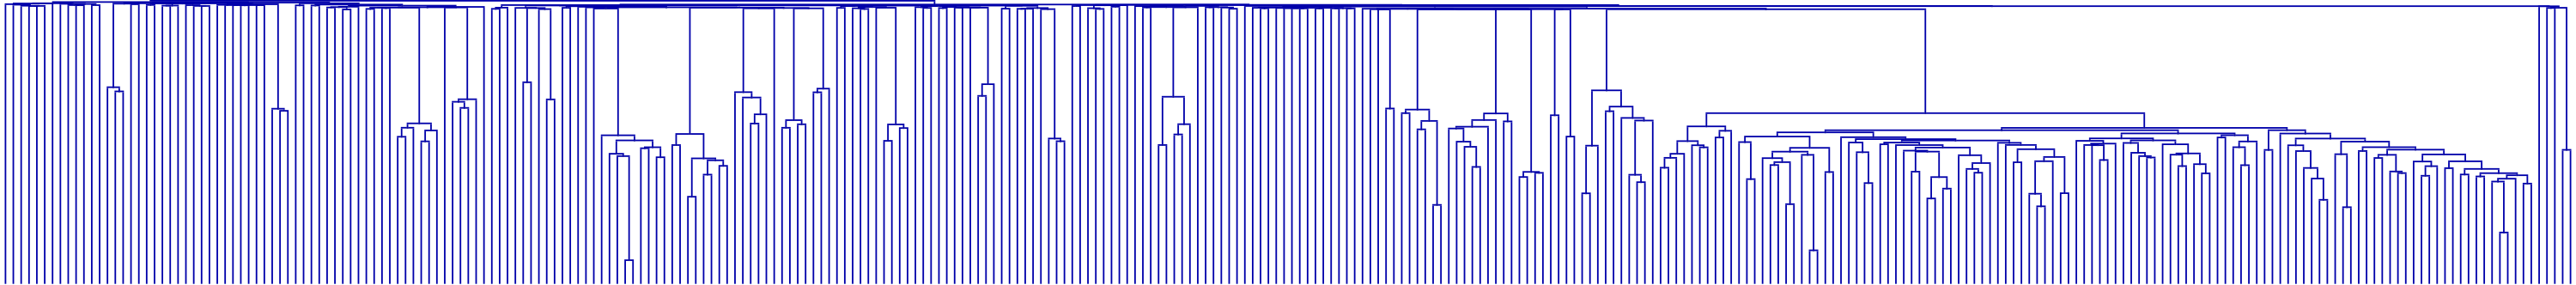

In [16]:
ms = TreeStyle()
ms.show_leaf_name = False
ms.show_branch_length = False
ms.branch_vertical_margin = 4
ms.show_branch_support = False
ms.draw_guiding_lines = False
ms.aligned_header = False
ms.legend = False
ms.show_scale = False
#ts.scale = 3000
ms.rotation = 90



for n in michel.traverse():
      n.set_style(diff_anc_style)


michel.render("%%inline", units="px",w = 3000, tree_style=ms)